<h1><center>CS 584 Assignment 3 : Discriminative Learning</center><h1>

###2 Class Discrimination using Logistic Regression:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as mpl
from sklearn.cross_validation import KFold 
from sklearn.preprocessing import PolynomialFeatures
from collections import defaultdict
import math
from sklearn.datasets import fetch_mldata
import os
from pylab import *
import cPickle, gzip

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def replace_zero(x):
    '''
    To avoid divide by zero errors.
    '''
    if x == 0 :
        return 1
    else:
        return x

In [4]:
def print_perf_measures(conf_matrix,perf_measures):
    '''Print the Performance Measures'''
    
    print '\nConfusion Matrix : \n' + str(conf_matrix) + '\n'
    print 'Accuracy : ' + '\n' + str(perf_measures['acc'])

    #Precision,Recall and F-Measure :
    for cls in perf_measures['rec'].keys():
        print 'Precision of class '+ str(cls) + ' is : \n' + str(perf_measures['prec'][cls])
        print 'Recall of class '+ str(cls) + ' is : \n' + str(perf_measures['rec'][cls])
        print 'F-Measure of class '+ str(cls) + ' is : \n' + str(perf_measures['F-Measure'][cls])
        print ''


In [5]:
def evaluate_performance(conf_matrix):
    '''
    For a confusion matrix, compute accuracy, precison, recall and F-Measure.
    '''    
    measure_and_value = defaultdict(lambda : defaultdict(lambda : 0.0) )
    
    #Accuracy
    measure_and_value['acc'] = float(conf_matrix.trace())/replace_zero(np.sum(conf_matrix))
    
    #Precision
    for r_num,row in enumerate(conf_matrix):
        measure_and_value['prec'][r_num+1] = conf_matrix[r_num,r_num] / replace_zero(sum(row))
    
    
    conf_mat_trans = np.transpose(conf_matrix)
    
    #Recall
    for r_num,row in enumerate(conf_mat_trans):
        measure_and_value['rec'][r_num+1] = conf_mat_trans[r_num,r_num] / replace_zero(sum(row))
    
    #F-Measure
    for j in measure_and_value['rec'].keys():
        nr = 2 * measure_and_value['prec'][j] * measure_and_value['rec'][j]
        dr = measure_and_value['prec'][j] + measure_and_value['rec'][j]
        
        measure_and_value['F-Measure'][j] = float(nr) / replace_zero(dr)
            
    return measure_and_value

###Hypothesis : $h_\theta(X^{i}) = \frac{1}{1 + e^{-\theta^T.X^i}}$

In [6]:
def h_theta(theta,x_i):
    '''Return the P(y=1|x;theta)'''
    z = np.dot((np.transpose(theta)),x_i)
    denom = 1 + np.exp(-z)
    return 1.0/denom

####Perform Gradient Descent until $\theta$ Converges:
###$\theta = \theta - \eta\frac{1}{m}\sum_{i=1}^m (h_\theta(X^{i}) - y^i).X^i$

In [7]:
def gradient_descent(X,Y,num_iterations,lrn_rate=0.0001,poly_deg=1,print_theta=9):
    '''
    Perform Gradient Descent iteratively, until J(theta) becomes minimum.    
    '''   
    theta_vec = np.zeros(len(X[0]))    
    no_of_examples = len(Y)
    
    for j in range(1,num_iterations+1):
        
        err_sum_vec = np.zeros(len(X[0]))
        #Iterate over all data points
        for i in range(0,no_of_examples):
            
            prob = h_theta(theta_vec,X[i])            
            if prob > 0.5:
                pred_lbl = 1
            else:
                pred_lbl = 0
            
            err_sum_vec += (pred_lbl - Y[i])*np.array(X[i])
    
        err_sum_vec /= float(no_of_examples)
        err_sum_vec *= lrn_rate
        
        theta_vec = theta_vec - err_sum_vec
            
    return theta_vec

In [8]:
def predict(file_name,iterations,lrn_rate,poly_deg=1):        
    '''Compute the accuracy of predictions using K-fold'''
    
    
    data_matrix = np.loadtxt(file_name)
    row_len = len(data_matrix[0])
    
    kf = KFold(len(data_matrix),10)
        
    unique_classes = set(data_matrix[:,row_len-1])
    #binarize
    no_of_classes = len(set([0 if y!=1 else 1 for y in unique_classes]))
    conf_matrix = np.zeros((no_of_classes,no_of_classes))
    
    for tr_row_nums,tst_row_nums in kf:        
        
        X_train = []
        Y_train = []

        X_test = []
        Y_test = []
        
        for row in tr_row_nums:
            X_train.append(list(data_matrix[row][0:row_len-1]))
            Y_train.append([data_matrix[row][row_len-1]])
        
        for row in tst_row_nums:
            X_test.append(list(data_matrix[row][0:row_len-1]))
            Y_test.append([data_matrix[row][row_len-1]])
    
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)

        X_test = np.array(X_test)
        Y_test = np.array(Y_test)
        
        #Binarize Labels
        Y_train = [0 if y!=1 else 1 for y in Y_train]
        Y_test  = [0 if y!=1 else 1 for y in Y_test]
        
        #Increase the dimensions of Feature matrix according to poly deg.
        poly = PolynomialFeatures(poly_deg)
        X_train = poly.fit_transform(X_train)
        
        poly = PolynomialFeatures(poly_deg)
        X_test = poly.fit_transform(X_test)
        
        theta_vec = gradient_descent(X_train,Y_train,iterations,lrn_rate,poly_deg,9)
        
        no_of_examples = len(Y_test)        
        
        for i in range(0,no_of_examples):       
        
            prob = h_theta(theta_vec,X_test[i])                      
            if prob > 0.5:
                pred_lbl = 1        
            else:
                pred_lbl = 0        

            conf_matrix[pred_lbl,Y_test[i]] += 1
    
    print 'Theta Vector ', theta_vec
    return conf_matrix

###Iterate 10 times, with a learning rate of 0.001 and poly order 1

In [9]:
conf_matrix = predict('iris.data',10,0.001,poly_deg=1)
perf_measures = evaluate_performance(conf_matrix)
print_perf_measures(conf_matrix,perf_measures)

Theta Vector  [ 0.0004      0.00026     0.0022237  -0.00424296 -0.0018363 ]

Confusion Matrix : 
[[ 99.   0.]
 [  1.  50.]]

Accuracy : 
0.993333333333
Precision of class 1 is : 
1.0
Recall of class 1 is : 
0.99
F-Measure of class 1 is : 
0.994974874372

Precision of class 2 is : 
0.980392156863
Recall of class 2 is : 
1.0
F-Measure of class 2 is : 
0.990099009901



###Iterate 10 times, with a learning rate of 0.001 and poly order 2

In [10]:
conf_matrix = predict('iris.data',10,0.001,poly_deg=2)
perf_measures = evaluate_performance(conf_matrix)
print_perf_measures(conf_matrix, perf_measures)

Theta Vector  [ 0.00048148  0.00164815  0.00201037 -0.00140963 -0.00073259  0.00335859
  0.00792852 -0.01101859 -0.00497059  0.00799393 -0.00313563 -0.00195378
 -0.01268511 -0.00461422 -0.00161904]

Confusion Matrix : 
[[ 100.    0.]
 [   0.   50.]]

Accuracy : 
1.0
Precision of class 1 is : 
1.0
Recall of class 1 is : 
1.0
F-Measure of class 1 is : 
1.0

Precision of class 2 is : 
1.0
Recall of class 2 is : 
1.0
F-Measure of class 2 is : 
1.0



###K-Class Discrimination using Logistic Regression with One-vs-all:
####$h_\theta^{(j)}(X^{i}) = P(y=j | x ; \theta)$      and                $ j \in $ {1,2,3...} 
####$ŷ = \underset{j}{\operatorname{argmax}} h_\theta^{(j)}(X)$ 

In [11]:
def binarize_wrt_class(Y,cls):
    '''Binarize the class labels.
    if label == cls, then set 1 else set 0
    '''
    return [0 if y!= cls else 1 for y in Y]

In [12]:
def multi_cls_train(file_name,iterations,lrn_rate,poly_deg=1):            
    '''Train a Logistic Regression classifier for k classes. 
       Return the theta vectors for all k classes'''
    
    data_matrix = np.loadtxt(file_name)
    row_len = len(data_matrix[0])
    
    X_matrix = data_matrix[:,:row_len-1]
    Y = data_matrix[:,row_len-1:]
    
    Y = [y[0] for y in Y.tolist()]
    unique_classes = set(Y)
    
    theta_j_vecs = []
    
    for cls_j in unique_classes:
        new_Y = binarize_wrt_class(Y,cls_j)
        
        #Increase the dimensions of Feature matrix according to poly deg.
        poly = PolynomialFeatures(poly_deg)
        new_X_matrix = poly.fit_transform(X_matrix)
        
        theta_vec = gradient_descent(new_X_matrix,new_Y,iterations,lrn_rate,poly_deg)
        theta_j_vecs.append(theta_vec)
    
    return theta_j_vecs

In [13]:
def multi_cls_test(file_name,theta_j_vecs,poly_deg=1):
    
    data_matrix = np.loadtxt(file_name)
    row_len = len(data_matrix[0])
    
    X_matrix = data_matrix[:,:row_len-1]
    Y = data_matrix[:,row_len-1:]
    
    Y = [y[0] for y in Y.tolist()]
    
    #binarize
    no_of_classes = len(set(Y))
    conf_matrix = np.zeros((no_of_classes,no_of_classes))
    
    for row, X in enumerate(X_matrix):
        
        poly = PolynomialFeatures(poly_deg)
        X = poly.fit_transform(X)
        
        max_prob = 0
        pred_class = -1
        
        for i in range(0,len(set(Y))):     
            pred_prob = h_theta(theta_j_vecs[i],X[0])
            
            if pred_prob > max_prob:
                max_prob = pred_prob
                pred_class = i+1
                
        conf_matrix[int(pred_class-1), int(Y[row]-1)] += 1
    
    return conf_matrix

###Iterate 1000 times, with a learning rate of 0.01 and polynomial order 2

In [14]:
poly_deg=2

theta_j_vecs = multi_cls_train('iris.data',1000,0.01,poly_deg)
print theta_j_vecs

conf_matrix = multi_cls_test('iris.data',theta_j_vecs,poly_deg)
perf_measures = evaluate_performance(conf_matrix)
print_perf_measures(conf_matrix, perf_measures)

[array([ 0.0062    ,  0.02256667,  0.02461333, -0.01378667, -0.00802667,
        0.05862467,  0.0992    , -0.11303067, -0.055218  ,  0.09481467,
       -0.030364  , -0.02177467, -0.13677333, -0.05202467, -0.019004  ]), array([ 0.06273333,  0.23431333,  0.02153333,  0.45573333,  0.13190667,
       -0.12045133, -0.20581333,  0.58842867, -0.01254867, -0.44425867,
        0.89982933,  0.27564933, -0.73844267, -0.583638  , -0.36141467]), array([-0.06553333, -0.22743333, -0.12871333, -0.12131333, -0.00158   ,
       -0.25513667, -0.23756333,  0.148236  ,  0.27943733, -0.201842  ,
       -0.00867267,  0.10623733,  0.306582  ,  0.27280067,  0.16071133])]

Confusion Matrix : 
[[ 50.   0.   0.]
 [  0.  49.   2.]
 [  0.   1.  48.]]

Accuracy : 
0.98
Precision of class 1 is : 
1.0
Recall of class 1 is : 
1.0
F-Measure of class 1 is : 
1.0

Precision of class 2 is : 
0.960784313725
Recall of class 2 is : 
0.98
F-Measure of class 2 is : 
0.970297029703

Precision of class 3 is : 
0.979591836735
Reca

##Multi-Layer Perceptron on a Feed Forward Neural Net:

In [33]:
def create_act_vecs(length,def_value=0.0):
    '''Create vectors of length length with the default values def_value'''
    return [def_value for i in range(0,length)]
        

In [34]:
create_act_vecs(3,0.6)

[0.6, 0.6, 0.6]

#####Step 1: Create a Neural Network with the required Architecture

In [17]:
def create_neural_net(no_ip_nodes,no_hdn_nodes,no_op_nodes,E=0.2):
    '''Create a NN in the form of a dictionary and return it.'''
    
    #Add a bias node
    no_ip_nodes = no_ip_nodes + 1

    #Initialize the activation vectors at each layer.
    ip_lyr_act_vector = create_act_vecs(no_ip_nodes,0.0)
    hdn_lyr_act_vector = create_act_vecs(no_hdn_nodes,0.0)
    op_lyr_act_vector = create_act_vecs(no_op_nodes,0.0)
    
    #Initialize the theta matrices at each layer.
    #Their Dimensions are Sl * S(l+1). Where Sl is the number of nodes at Layer l.
    ip_theta_mat = np.zeros((no_ip_nodes,no_hdn_nodes))
    op_theta_mat = np.zeros((no_hdn_nodes,no_op_nodes))

    #Randomize their values in the range -E <= Xij <= +E
    plus_E = +E
    minus_E = -E
        
    for i in range(no_ip_nodes):
        for j in range(no_hdn_nodes):
            ip_theta_mat[i,j] = (plus_E - minus_E) * np.random.random_sample() + minus_E
            
    for j in range(no_hdn_nodes):
        for k in range(no_op_nodes):
            op_theta_mat[j,k] = (plus_E - minus_E) * np.random.random_sample() + minus_E
    
    theta_mat = {'ip_theta_mat' : ip_theta_mat, 'op_theta_mat' : op_theta_mat}
    act_vec = {'ip_lyr_act_vector':ip_lyr_act_vector ,'hdn_lyr_act_vector':hdn_lyr_act_vector,'op_lyr_act_vector':op_lyr_act_vector}
    layer_nodes_cnt = {'no_ip_nodes':no_ip_nodes,'no_hdn_nodes':no_hdn_nodes,'no_op_nodes':no_op_nodes}
    
    neural_net = {'theta_mat' :theta_mat, 'act_vec': act_vec , 'layer_nodes_cnt' : layer_nodes_cnt}
    
    return neural_net
    

In [18]:
x = create_neural_net(2,3,2)

x['act_vec']['op_lyr_act_vector']

[0.0, 0.0]

#####Step 2: Train the Constructed neural net as follows:
Repeat until convergence
<br>{<br>
for i in range(1,m):<br>
1.Forward Propogate to get the activations vectors $a^{x}$ for x = {2,3,...L}, where x is the layer no<br>
2.Compute $\delta^{L} = a^{L} - y^{i}$ <br>
3.Compute $\delta^{L-1},\delta^{L-2}.....\delta^{2}$ by back propogating<br>
4.Crank up the $\theta^{l}_{ij}$ for all layers l = {1,2,3..} , all previous layer nodes i , all current layer nodes j<br>
}


In [19]:
def sigmoid(x):
    '''Return the sigmoid of x'''
    return 1.0/(1 + math.pow(math.e,-x))

In [20]:
def dx_sigmoid(x):
    '''Return the derivative which is x[1 - x] == x - x^2 '''
    return x - x**2

In [21]:
def forward_propogate(neural_net, X):
    '''Recompute the activations of all nodes at the hidden and output layers'''
    '''Return the neural net with activations'''
    
    no_hdn_nodes = neural_net['layer_nodes_cnt']['no_hdn_nodes']
    no_ip_nodes = neural_net['layer_nodes_cnt']['no_ip_nodes']
    no_op_nodes = neural_net['layer_nodes_cnt']['no_op_nodes']
    
    # Update the activations at Input Layer
    #Discard a node as it is the bias unit.    
    #The activations at the Input layer is nothing but the feature vectors fed to the Neural net.    
    for i in range(no_ip_nodes-1):      
        neural_net['act_vec']['ip_lyr_act_vector'][i] = X[i]       

    # Update the activations at Hidden Layer
    #The activations at the hidden layer is the sigmoid(weighted sum thetas and activations at input layer)
    '''
    for i in range(no_hdn_nodes):
        z = 0
        for j in range(no_ip_nodes):            
            z += neural_net['act_vec']['ip_lyr_act_vector'][j] * neural_net['theta_mat']['ip_theta_mat'][j][i]            
        neural_net['act_vec']['hdn_lyr_act_vector'][i] = sigmoid(z)      
    '''
    
    #Optimized code:
    for i in range(no_hdn_nodes):
        z = np.dot(np.transpose(neural_net['act_vec']['ip_lyr_act_vector']), neural_net['theta_mat']['ip_theta_mat'][:,i])
        neural_net['act_vec']['hdn_lyr_act_vector'][i] = sigmoid(z)
        
    # Update the activations at Output Layer
    #The activations at the Output layer is the sigmoid(weighted sum thetas and activations at Hidden layer)
    for i in range(no_op_nodes):                
        z = np.dot(np.transpose(neural_net['act_vec']['hdn_lyr_act_vector']), neural_net['theta_mat']['op_theta_mat'][:,i])            
        neural_net['act_vec']['op_lyr_act_vector'][i] = sigmoid(z)        

    return neural_net

In [22]:
def back_propagate(neural_net,Y, lrn_rate):
    '''Back Propogate to compute deltas at Hidden and output layers'''
    
    no_hdn_nodes = neural_net['layer_nodes_cnt']['no_hdn_nodes']
    no_ip_nodes = neural_net['layer_nodes_cnt']['no_ip_nodes']
    no_op_nodes = neural_net['layer_nodes_cnt']['no_op_nodes']
    
    # Compute deltas at output layer :    
    # delta at output layer is true labels(Y) - activations
    
    output_deltas = create_act_vecs(no_op_nodes,0.0)
    
    for i in range(no_op_nodes):
        output_deltas[i] = Y[i]-neural_net['act_vec']['op_lyr_act_vector'][i]        

    '''
    # Compute deltas at hidden layer :          
    hidden_deltas = create_act_vecs(no_hdn_nodes,0.0)
    for j in range(no_hdn_nodes):
        part1 = 0
        for k in range(no_op_nodes):            
            part1 +=output_deltas[k]*neural_net['theta_mat']['op_theta_mat'][j][k]
        hidden_deltas[j] = dx_sigmoid(neural_net['act_vec']['hdn_lyr_act_vector'][j]) * part1
    '''
    #Optimize.
    hidden_deltas = create_act_vecs(no_hdn_nodes,0.0)
    for j in range(no_hdn_nodes):                
        z = np.dot( np.transpose(output_deltas) , neural_net['theta_mat']['op_theta_mat'][j] )
        hidden_deltas[j] = dx_sigmoid(neural_net['act_vec']['hdn_lyr_act_vector'][j]) * z

    # Crank up the output theta matrix
    for j in range(no_hdn_nodes):        
        update = np.dot( np.transpose(output_deltas) , neural_net['act_vec']['hdn_lyr_act_vector'][j])
        neural_net['theta_mat']['op_theta_mat'][j] = neural_net['theta_mat']['op_theta_mat'][j] + (update*lrn_rate)

    # Crank up the input theta matrix
    for i in range(no_ip_nodes):        
            update = np.dot( np.transpose(hidden_deltas) , neural_net['act_vec']['ip_lyr_act_vector'][i] )
            neural_net['theta_mat']['ip_theta_mat'][i] = neural_net['theta_mat']['ip_theta_mat'][i] +(update*lrn_rate)               

    # calculate Sum of square error    
    error = 0.0
    for i in range(len(Y)):
        error = error + 0.5*(Y[i]-neural_net['act_vec']['op_lyr_act_vector'][i] )**2
        
    return neural_net, error

In [23]:
def vectorize_labels(y,distinct_classes):
    '''Vectorize the labels according to the total number of distinct classes.'''
    '''Example : if y = 2 and distinct_classes = [1,2,3,4] then return [0,1,0,0]'''
    x = np.zeros(len(distinct_classes),dtype=int).tolist()
    x[distinct_classes.index(y)] = 1
    return x

In [24]:
def train(neural_net,file_name, iterations=1000, lrn_rate=0.5,MNIST='N',X_train=None,y_train=None):    
    '''Train the neural and return the weights'''
    
    if MNIST == 'N':
        data_matrix = np.loadtxt(file_name)
        row_len = len(data_matrix[0])    

        #Segregate Features and labels
        X_matrix = data_matrix[:,:row_len-1]
        Y = data_matrix[:,row_len-1:]

        new_Y = []
        for y in Y:
            new_Y.append(y[0])

        distinct_labels = list(set(new_Y))
    else:
        X_matrix = X_train
        new_Y = y_train
        distinct_labels = list(set(new_Y))
        
    for i in range(iterations):
        error = 0
        for r_id,X in enumerate(X_matrix):                                    
            neural_net = forward_propogate(neural_net,X)
            y_vec = vectorize_labels(new_Y[r_id],distinct_labels)
            neural_net,error = back_propagate(neural_net,y_vec, lrn_rate)
            if MNIST == 'Y' and r_id % 100 == 0:
                print r_id
        if i % 100 == 0:
            print('error %-.5f' % error)
    
    return neural_net

In [25]:
def predict(X,trained_neural_net):
    '''Predict the probabilities of class labels'''
    for x in X:
        nn = forward_propogate(trained_neural_net, x)
        return nn['act_vec']['op_lyr_act_vector']

<b>Iris dataset has 4 features and 3 distinct class labels.<br>
So lets create a Neural Net with 4 nodes at Input Layer, 3 nodes at output Layer, and 5 nodes at Hidden Layer</b>

In [26]:
neural_net = create_neural_net(4,5,3)
print neural_net

{'theta_mat': {'ip_theta_mat': array([[ -8.07059697e-02,  -1.16583811e-01,   1.98131696e-02,
          1.41109676e-04,  -4.08319304e-02],
       [  9.16694818e-02,   1.50593668e-02,  -1.36295150e-01,
         -2.10314918e-02,  -1.93061252e-01],
       [  1.23547391e-01,  -1.91039868e-01,   5.98450142e-02,
          1.03966950e-01,  -3.79857818e-02],
       [  1.10945360e-01,  -1.01767953e-01,   5.17447872e-02,
          1.02644063e-01,   1.00557101e-01],
       [ -2.25275296e-03,  -9.06057584e-02,  -1.17788396e-01,
          1.66364772e-01,  -1.29010166e-01]]), 'op_theta_mat': array([[ 0.02745992, -0.04764043, -0.15839701],
       [ 0.0495422 , -0.09854901,  0.08469571],
       [ 0.17376778, -0.18651834, -0.01312286],
       [-0.1097595 , -0.19315933, -0.01681882],
       [ 0.1341492 ,  0.19357196, -0.03032351]])}, 'act_vec': {'ip_lyr_act_vector': [0.0, 0.0, 0.0, 0.0, 0.0], 'op_lyr_act_vector': [0.0, 0.0, 0.0], 'hdn_lyr_act_vector': [0.0, 0.0, 0.0, 0.0, 0.0]}, 'layer_nodes_cnt': {'no_o

<b>Lets train this 4x5x3 Neural Net with the iris dataset<br>
Let's chose a learning rate of 0.06 and lets iterate 2000 times.
</b>

In [27]:
trained_neural_net = train(neural_net,'iris.data',2000,0.06)
print trained_neural_net

error 0.01660
error 0.00013
error 0.00016
error 0.00000
error 0.00023
error 0.00010
error 0.00013
error 0.00009
error 0.00109
error 0.00046
error 0.00000
error 0.00010
error 0.00000
error 0.00130
error 0.00002
error 0.00005
error 0.00008
error 0.00213
error 0.00017
error 0.00009
{'theta_mat': {'ip_theta_mat': array([[ -9.13100850e+00,   2.85575151e+01,  -3.10528510e-01,
         -2.33526601e+00,  -8.68367990e-01],
       [ -9.47704708e+00,   2.63053325e+01,   1.75699316e+00,
          1.39898974e+00,  -3.07556881e+00],
       [  1.04529948e+01,  -3.89584358e+01,   2.07222318e+00,
         -8.03584660e-01,   4.76492042e+00],
       [  1.61612118e+01,  -3.99221335e+01,   4.34647124e+00,
          1.83306582e+00,   2.34995538e+00],
       [ -2.25275296e-03,  -9.06057584e-02,  -1.17788396e-01,
          1.66364772e-01,  -1.29010166e-01]]), 'op_theta_mat': array([[ -1.73653258,  -5.05195097,   4.8520262 ],
       [  5.74757169,   6.66387606,  -6.90344844],
       [  2.03697314, -13.73747348

<b>Time for predictions. <br> Lets predict and compute confusion matrix for entries in iris dataset</b>

In [28]:
def predict_and_evaluate_performance(file_name,MNIST='N',X_matrix=None,Y=None):
    '''For all examples,Predict the probabilities for all classes, and the assign the class label with max probability'''
    
    if MNIST == 'N' :
        data_matrix = np.loadtxt(file_name)
        row_len = len(data_matrix[0])    
        X_matrix = data_matrix[:,:row_len-1]

        Y = data_matrix[:,row_len-1:]

        Y = [y[0] for y in Y.tolist()]
    

    no_of_classes = len(set(Y))
    conf_matrix = np.zeros((no_of_classes,no_of_classes))

    for row,X in enumerate(X_matrix):    
        class_probs = predict([X],trained_neural_net)

        predicted_class = class_probs.index(max(class_probs))
        
        if MNIST == 'N':
            true_lbl = int(Y[row]-1)
        else:
            true_lbl = int(Y[row])
            
        conf_matrix[predicted_class,true_lbl] += 1

    perf_measures = evaluate_performance(conf_matrix)
    print_perf_measures(conf_matrix,perf_measures)


In [29]:
predict_and_evaluate_performance('iris.data')


Confusion Matrix : 
[[ 50.   0.   0.]
 [  0.  46.   0.]
 [  0.   4.  50.]]

Accuracy : 
0.973333333333
Precision of class 1 is : 
1.0
Recall of class 1 is : 
1.0
F-Measure of class 1 is : 
1.0

Precision of class 2 is : 
1.0
Recall of class 2 is : 
0.92
F-Measure of class 2 is : 
0.958333333333

Precision of class 3 is : 
0.925925925926
Recall of class 3 is : 
1.0
F-Measure of class 3 is : 
0.961538461538



<b> Let's increase the number of hidden units to 8 and observe the performance </b><br>
<b> So, the dimensions of the new neural net is : 4x8x3 </b>

In [32]:
#Create neural net
neural_net = create_neural_net(4,8,3)
print neural_net

#Train neural net
trained_neural_net = train(neural_net,'iris.data',2000,0.06)
print trained_neural_net

#Evaluate performance
predict_and_evaluate_performance('iris.data')

{'theta_mat': {'ip_theta_mat': array([[ 0.00116256, -0.06293263, -0.10803242,  0.19619404,  0.19246331,
         0.10481931,  0.0770353 , -0.13862009],
       [ 0.19808414,  0.02441997,  0.12915653, -0.16692361, -0.00107777,
        -0.08382041,  0.02714061,  0.11172736],
       [-0.05969833,  0.09408224, -0.01841783,  0.01932991, -0.19675585,
         0.06808777,  0.15368515,  0.08317641],
       [ 0.18655725, -0.11543166, -0.08986352,  0.0475849 , -0.04482657,
        -0.16614241, -0.06634655,  0.06894761],
       [-0.01542019,  0.0721697 , -0.06091166, -0.09302769, -0.15057134,
         0.18010146, -0.16659208,  0.19514135]]), 'op_theta_mat': array([[ 0.15811682, -0.18341296,  0.12565874],
       [-0.13843614, -0.01761117, -0.19183185],
       [ 0.08352862, -0.17937782,  0.06028842],
       [ 0.12135665,  0.1377123 , -0.13201343],
       [ 0.14508623,  0.19605301,  0.115217  ],
       [-0.08517319,  0.19443561, -0.05953836],
       [ 0.12797725, -0.00968097,  0.18262659],
       [ 0

###Multi Layer Perceptron on a Feed Forward Neural Network for MNIST digits image data

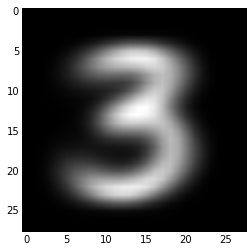

In [36]:
# Load the dataset
f = gzip.open('mnist.pkl.gz', 'rb')
train_set, valid_set, test_set = cPickle.load(f)

X_train,y_train = train_set[0],train_set[1]
X_test,y_test = test_set[0],test_set[1]

size=len(y_train)

f.close()

size=len(y_train)
ind = [ k for k in range(size) if y_train[k]==3 ]
extracted_images=X_train[ind,:]

mean_image=extracted_images.mean(axis=0)
imshow(mean_image.reshape(28,28), cmap=cm.gray)

<b> Create a Neural network with 784 input nodes, 785 hidden layer nodes and 10 output layer nodes<br></b>

In [37]:
ip_nodes = X_train.shape[1]
neural_net = create_neural_net(ip_nodes,ip_nodes + 1, 10)
print 'created a neural net'

created a neural net


<b> Train the Neural net on 5000 examples, with a learning rate of 0.06 by iterating 2 times </b>

In [38]:
#Train on the first 5000 examples
small_X_train = X_train[:5000]
small_y_train = y_train[:5000]

trained_neural_net = train(neural_net,'mnist_dataset',2,0.06,'Y',small_X_train,small_y_train)
print 'train complete'

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
error 0.01336
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
train complete


In [40]:
#Test on 1000 examples 
small_X_train = X_test[:1000]
small_y_test = y_test[:1000]

predict_and_evaluate_performance('mnist_dataset','Y',small_X_train,small_y_test)


Confusion Matrix : 
[[  84.    0.    0.    1.    0.    1.    3.    0.    1.    0.]
 [   0.  125.    0.    0.    2.    0.    0.    5.    0.    1.]
 [   0.    0.  108.    6.    1.    0.    0.    4.    1.    0.]
 [   0.    0.    0.   82.    0.    0.    0.    0.    2.    0.]
 [   0.    0.    0.    1.  101.    2.    1.    3.    3.    3.]
 [   0.    0.    1.    5.    0.   77.    1.    0.    2.    2.]
 [   1.    1.    0.    2.    1.    3.   80.    0.    0.    0.]
 [   0.    0.    3.    5.    0.    2.    2.   84.    1.    3.]
 [   0.    0.    2.    4.    0.    2.    0.    1.   78.    2.]
 [   0.    0.    2.    1.    5.    0.    0.    2.    1.   83.]]

Accuracy : 
0.902
Precision of class 1 is : 
0.933333333333
Recall of class 1 is : 
0.988235294118
F-Measure of class 1 is : 
0.96

Precision of class 2 is : 
0.93984962406
Recall of class 2 is : 
0.992063492063
F-Measure of class 2 is : 
0.965250965251

Precision of class 3 is : 
0.9
Recall of class 3 is : 
0.931034482759
F-Measure of class 3 i